# Phase 3 Project
- author: Jonathan Holt
- Flatiron Data Science
- 7/19/21 Cohort

## Business Problem

SyriaTel is a telecommunications company that wants to identify what factors play a part in customer churn, ie, leaving their service. I have been tasked with with analyizing the data provided and providing recommendations as to what they can do to better retain ccustomers.

## The Data

The dataset that I was given to work with contains information for 3333 accounts, including:
- State
- Account Length
- Area Code
- Phone Number
- Extra Plans (VoiceMail and/or International)
- Minutes Used (Day, Evening, Night, International)
- Number of Calls (Day, Evening, Night, International)
- Number of VoiceMail Messages
- Total Amount Charged for minutes used (Day, Evening, Night, International)
- Number of calls to Customer Service

and most importantly:
- Churn: Customers who cancelled their service.

## Questions to Answer
1. What is the Baseline Churn Rate?
2. What factors contribute to churn?
3. What factors have the biggest impact on churn?
4. What can be done to identify when a customer is at risk for churn?
5. What can be done to prevent churn?

# Data Preparation

## Importing

In [144]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as mtick
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, mean_squared_log_error, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import plot_confusion_matrix

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
pd.set_option('display.max_rows', 1000) #change the amount of rows displayed
plt.style.use('ggplot')

In [3]:
df = pd.read_csv('bigml_59c28831336c6604c800002a.csv')
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


## Fixing column names

In [4]:
df.columns = df.columns.str.replace(' ','_')
df.columns

Index(['state', 'account_length', 'area_code', 'phone_number',
       'international_plan', 'voice_mail_plan', 'number_vmail_messages',
       'total_day_minutes', 'total_day_calls', 'total_day_charge',
       'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
       'total_night_minutes', 'total_night_calls', 'total_night_charge',
       'total_intl_minutes', 'total_intl_calls', 'total_intl_charge',
       'customer_service_calls', 'churn'],
      dtype='object')

## Inital Data Exploration

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account_length          3333 non-null   int64  
 2   area_code               3333 non-null   int64  
 3   phone_number            3333 non-null   object 
 4   international_plan      3333 non-null   object 
 5   voice_mail_plan         3333 non-null   object 
 6   number_vmail_messages   3333 non-null   int64  
 7   total_day_minutes       3333 non-null   float64
 8   total_day_calls         3333 non-null   int64  
 9   total_day_charge        3333 non-null   float64
 10  total_eve_minutes       3333 non-null   float64
 11  total_eve_calls         3333 non-null   int64  
 12  total_eve_charge        3333 non-null   float64
 13  total_night_minutes     3333 non-null   float64
 14  total_night_calls       3333 non-null   

In [6]:
df.isna().sum()

state                     0
account_length            0
area_code                 0
phone_number              0
international_plan        0
voice_mail_plan           0
number_vmail_messages     0
total_day_minutes         0
total_day_calls           0
total_day_charge          0
total_eve_minutes         0
total_eve_calls           0
total_eve_charge          0
total_night_minutes       0
total_night_calls         0
total_night_charge        0
total_intl_minutes        0
total_intl_calls          0
total_intl_charge         0
customer_service_calls    0
churn                     0
dtype: int64

In [7]:
df.phone_number.duplicated().sum()

0

In [8]:
df.churn.value_counts()

False    2850
True      483
Name: churn, dtype: int64

## Initial Analysis

### Base Churn Rate: 14.49%
- There are 3333 records.
- No missing values, and no duplicates.
- The number of customers who churned was 483.
- Therefore the base churn rate is (483 / 3333) = 14.49%

### Target Feature Class Imbalance
- Churn is very imbalanced as the amount of customers sho stay with the company is nearly 6X higher than the number of customers who leave.
- Class imbalance will need to be addressed in my models through one of (or a combination of) these options:
1. class weight parameters
2. oversampling or undersampling
3. Synthetic Minority Oversampling (SMOTE)

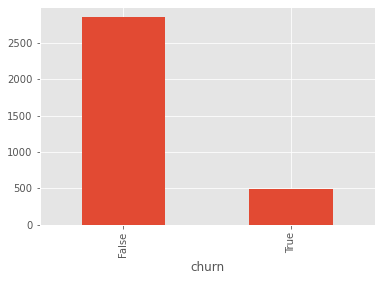

In [9]:
imbalance_data = df.pivot_table(index='churn', aggfunc='size').plot(kind='bar')
imbalance_data;

# Cleaning and Preprocessing

In [10]:
test_df = df.copy()
test_df.head(2)

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.7,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.7,1,False


## Changing False to 0 and True to 1

In [11]:
test_df["churn"] = test_df["churn"].astype(int)
test_df.churn.value_counts()

0    2850
1     483
Name: churn, dtype: int64

## Dropping Uneccesary Columns

In [12]:
#test_df = test_df.drop(columns=['state','phone_number', 'area_code'], axis=1)

## Adding Column: Total Charge
- This column captures the total charge that the customer will see on their bill from all charges contained within the dataset.

In [13]:
total_charge = test_df.apply(lambda x: x['total_day_charge'] + x['total_eve_charge'] +x['total_night_charge']
                             +x['total_intl_charge'], axis=1)
test_df['total_charge']= total_charge

## Slicing out object type Features

In [14]:
cont_features = [col for col in test_df.columns if test_df[col].dtype in [np.float64, np.int64]]
feature_df = test_df.loc[:, cont_features]
feature_df.head()

,account_length,area_code,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn,total_charge
0,128,415,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0,75.56
1,107,415,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0,59.24
2,137,415,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0,62.29
3,84,408,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0,66.80
4,75,415,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0,52.09


## One Hot Encoding

In [15]:
need_to_encode = test_df[['international_plan', 'voice_mail_plan', 'customer_service_calls']]
ohe = OneHotEncoder()
ohe.fit(need_to_encode)

ohe_1 = ohe.transform(need_to_encode).toarray()

ohe_df = pd.DataFrame(ohe_1, columns=ohe.get_feature_names(need_to_encode.columns))
ohe_df.head(2)

,international_plan_no,international_plan_yes,voice_mail_plan_no,voice_mail_plan_yes,customer_service_calls_0,customer_service_calls_1,customer_service_calls_2,customer_service_calls_3,customer_service_calls_4,customer_service_calls_5,customer_service_calls_6,customer_service_calls_7,customer_service_calls_8,customer_service_calls_9
0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# Combining everything together
cleaned_df = pd.concat([pd.DataFrame(feature_df), ohe_df], axis=1)
cleaned_df.head(2)

,account_length,area_code,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,...,customer_service_calls_0,customer_service_calls_1,customer_service_calls_2,customer_service_calls_3,customer_service_calls_4,customer_service_calls_5,customer_service_calls_6,customer_service_calls_7,customer_service_calls_8,customer_service_calls_9
0,128,415,25,265.1,110,45.07,197.4,99,16.78,244.7,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,107,415,26,161.6,123,27.47,195.5,103,16.62,254.4,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Decision Tree 1 (Baseline Model)

In [17]:
#Setting Target
X = cleaned_df.drop(['churn'], axis=1)
y = cleaned_df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=23)

In [18]:
dt1 = DecisionTreeClassifier(random_state=23)
dt1.fit(X_train, y_train)
dt1_y_pred = dt1.predict(X_test)

## Metrics Function

In [19]:
def get_metrics(clf, y_pred):
    
    clf_acc = accuracy_score(y_test, y_pred) * 100
    print('Accuracy is :{0}'.format(clf_acc))
    clf_prec = precision_score(y_test, y_pred) * 100
    print('Precision is :{0}'.format(clf_prec))
    clf_rcl = recall_score(y_test, y_pred) * 100
    print('Recall is :{0}'.format(clf_rcl))
    clf_f1 = f1_score(y_test, y_pred) * 100
    print('F1 Score is :{0}'.format(clf_f1))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    clf_roc_auc = auc(false_positive_rate, true_positive_rate)
    print('ROC AUC is :{0}'.format(round(clf_roc_auc, 2)))
    

In [20]:
get_metrics(dt1, dt1_y_pred)

Accuracy is :96.1630695443645
Precision is :86.15384615384616
Recall is :88.88888888888889
F1 Score is :87.50000000000001
ROC AUC is :0.93


In [21]:
dt1_rcl = recall_score(y_test, dt1_y_pred) * 100
print('DT 1 Recall is :{0}'.format(dt1_rcl))

DT 1 Recall is :88.88888888888889


## ANALYSIS OF BASELINE MODEL

Analyisis goes HERE

# Refining Data

In [22]:
cleaned_df_2 = cleaned_df.copy()
cleaned_df_2

,account_length,area_code,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,...,customer_service_calls_0,customer_service_calls_1,customer_service_calls_2,customer_service_calls_3,customer_service_calls_4,customer_service_calls_5,customer_service_calls_6,customer_service_calls_7,customer_service_calls_8,customer_service_calls_9
0,128,415,25,265.1,110,45.07,197.4,99,16.78,244.7,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,107,415,26,161.6,123,27.47,195.5,103,16.62,254.4,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,137,415,0,243.4,114,41.38,121.2,110,10.30,162.6,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,84,408,0,299.4,71,50.90,61.9,88,5.26,196.9,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,75,415,0,166.7,113,28.34,148.3,122,12.61,186.9,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,192,415,36,156.2,77,26.55,215.5,126,18.32,279.1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3329,68,415,0,231.1,57,39.29,153.4,55,13.04,191.3,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3330,28,510,0,180.8,109,30.74,288.8,58,24.55,191.9,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3331,184,510,0,213.8,105,36.35,159.6,84,13.57,139.2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Dropping Unecessary Columns

In [23]:
cleaned_df_2 = cleaned_df_2.drop(columns=['area_code'], axis=1)

## Dropping one value for categoricals

In [24]:
#Dropping a few of the redundant values.
cleaned_df_2 = cleaned_df_2.drop(['international_plan_no', 'voice_mail_plan_no'], axis=1)
cleaned_df_2.head(2)

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,...,customer_service_calls_0,customer_service_calls_1,customer_service_calls_2,customer_service_calls_3,customer_service_calls_4,customer_service_calls_5,customer_service_calls_6,customer_service_calls_7,customer_service_calls_8,customer_service_calls_9
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Creating Variable: Customer Service Calls High
- If Customer Service Calls High = 4 or more Customer Service Calls

In [25]:
#cs_calls_low = cleaned_df_2.apply(lambda x: x['customer_service_calls_0']+ x['customer_service_calls_1'] + x['customer_service_calls_2']
#                              + x['customer_service_calls_3'], axis=1)
cs_calls_high= cleaned_df_2.apply(lambda x: x['customer_service_calls_4'] + x['customer_service_calls_5']
                              + x['customer_service_calls_6'] + x['customer_service_calls_7']
                            + x['customer_service_calls_8']+ x['customer_service_calls_9'], axis=1)

#cleaned_df['cs_calls_low'] = cs_calls_low
cleaned_df_2['cs_calls_high'] = cs_calls_high



In [26]:
cleaned_df_2 = cleaned_df_2.drop(['customer_service_calls_0', 'customer_service_calls_1','customer_service_calls_2','customer_service_calls_3',
                     'customer_service_calls_4','customer_service_calls_5','customer_service_calls_6',
                     'customer_service_calls_7','customer_service_calls_8','customer_service_calls_9']
                    , axis=1)
cleaned_df_2.head(2)

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn,total_charge,international_plan_yes,voice_mail_plan_yes,cs_calls_high
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.7,1,0,75.56,0.0,1.0,0.0
1,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.7,1,0,59.24,0.0,1.0,0.0


In [27]:
#dropping cs_calls_low as it is redundant since this is now a binary choice.
#ohe_df = ohe_df.drop(['cs_calls_low', 'customer_service_calls_0'], axis=1)
#cleaned_df_2= cleaned_df_2.drop(['customer_service_calls_0'], axis=1)

In [28]:
total_charge = cleaned_df_2.apply(lambda x: x['total_day_charge'] + x['total_eve_charge'] +x['total_night_charge']
                             +x['total_intl_charge'], axis=1)
cleaned_df_2['total_charge']= total_charge

## Creating Model DataFrame

In [29]:
model_df = cleaned_df_2.copy()
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   account_length          3333 non-null   int64  
 1   number_vmail_messages   3333 non-null   int64  
 2   total_day_minutes       3333 non-null   float64
 3   total_day_calls         3333 non-null   int64  
 4   total_day_charge        3333 non-null   float64
 5   total_eve_minutes       3333 non-null   float64
 6   total_eve_calls         3333 non-null   int64  
 7   total_eve_charge        3333 non-null   float64
 8   total_night_minutes     3333 non-null   float64
 9   total_night_calls       3333 non-null   int64  
 10  total_night_charge      3333 non-null   float64
 11  total_intl_minutes      3333 non-null   float64
 12  total_intl_calls        3333 non-null   int64  
 13  total_intl_charge       3333 non-null   float64
 14  customer_service_calls  3333 non-null   

In [30]:
model_df=model_df.drop(['customer_service_calls','total_day_charge', 'total_eve_charge', 'total_night_charge', 'total_intl_charge']
                           , axis=1)

In [31]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   account_length          3333 non-null   int64  
 1   number_vmail_messages   3333 non-null   int64  
 2   total_day_minutes       3333 non-null   float64
 3   total_day_calls         3333 non-null   int64  
 4   total_eve_minutes       3333 non-null   float64
 5   total_eve_calls         3333 non-null   int64  
 6   total_night_minutes     3333 non-null   float64
 7   total_night_calls       3333 non-null   int64  
 8   total_intl_minutes      3333 non-null   float64
 9   total_intl_calls        3333 non-null   int64  
 10  churn                   3333 non-null   int64  
 11  total_charge            3333 non-null   float64
 12  international_plan_yes  3333 non-null   float64
 13  voice_mail_plan_yes     3333 non-null   float64
 14  cs_calls_high           3333 non-null   

# Decision Tree 2

In [32]:
#Setting Target
X = model_df.drop(['churn'], axis=1)
y = model_df['churn']

In [33]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y, random_state=23)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=23)

In [34]:
#dtree_1 = DecisionTreeClassifier(random_state=23)
#dtree_1.fit(X_train, y_train)
#dt1_y_pred = dtree_1.predict(X_test)

In [35]:
dt2 = DecisionTreeClassifier(random_state=23)
dt2.fit(X_train, y_train)
dt2_y_pred = dt2.predict(X_test)

In [36]:
get_metrics(dt2, dt2_y_pred)

Accuracy is :96.1630695443645
Precision is :86.15384615384616
Recall is :88.88888888888889
F1 Score is :87.50000000000001
ROC AUC is :0.93


In [37]:
# Create and print a confusion matrix 
print('\n DT 2 Confusion Matrix')
print('----------------')
pd.crosstab(y_test, dt2_y_pred, rownames=['True'], colnames=['Predicted'], margins=True)


 DT 2 Confusion Matrix
----------------


Predicted,0,1,All
True,,,
0,690,18,708
1,14,112,126
All,704,130,834


### Analysis

### Analysis of Accuracy, AUC, and Confusion Matrix
- Analysis goes HERE
- AND HERE
- AND HERE!

# Dealing With Churn Class Imbalance 
- adding class weight Decision Tree Classifier
- Adding stratify to Test Train Split
- Adding SMOTE to Dataset.

In [38]:
balanced_df = model_df.copy()

X = balanced_df.drop(['churn'], axis=1)
y = balanced_df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y, random_state=23)

smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 

# Decision Tree 3

In [39]:
dt3 = DecisionTreeClassifier(random_state=23, class_weight="balanced")
dt3.fit(X_train_resampled, y_train_resampled)
dt3_y_pred = dt3.predict(X_test)

In [40]:
get_metrics(dt3, dt3_y_pred)

Accuracy is :94.7242206235012
Precision is :80.80000000000001
Recall is :83.47107438016529
F1 Score is :82.11382113821138
ROC AUC is :0.9


## Refinig Decision Tree through GridSearchCV

In [41]:
#2/22 added class weight parameter
#dtree_2 = DecisionTreeClassifier(random_state=23, class_weight="balanced")

In [42]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

In [43]:
# Instantiate GridSearchCV
#dt3_grid_search = GridSearchCV(dt3, dt_param_grid, cv=3, scoring = 'recall', return_train_score=True)
dt3_grid_search = GridSearchCV(dt3, dt_param_grid, cv=3, scoring = 'f1', return_train_score=True)

# Fit to the data
dt3_grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=23),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 3, 4, 5, 6],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [2, 5, 10]},
             return_train_score=True, scoring='f1')

In [44]:
dt3_grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 6,
 'min_samples_leaf': 4,
 'min_samples_split': 2}

# Decision Tree 4 (Using Grid Search Parameters)

In [45]:
dt4 = DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_split=2,
                             min_samples_leaf=3, class_weight='balanced', random_state=23)
dt4.fit(X_train_resampled, y_train_resampled)
dt4_y_pred = dt4.predict(X_test)

In [46]:
get_metrics(dt4, dt4_y_pred)

Accuracy is :97.3621103117506
Precision is :99.00990099009901
Recall is :82.64462809917356
F1 Score is :90.0900900900901
ROC AUC is :0.91


In [47]:
# Mean training score
#dt3_gs_training_score = np.mean(dt3_grid_search.cv_results_['mean_train_score'])

# Mean test score
#dt3_gs_testing_score = dt3_grid_search.score(X_test, y_test)

#print(f"DTree 2 Mean Training Score: {dt2_gs_training_score :.2%}")
#print(f"DTree 2 Mean Test Score: {dt2_gs_testing_score :.2%}")
#print("DTree 2 Best Parameter Combination Found During Grid Search:")
#dt2_grid_search.best_params_

# Random Forests 1

In [48]:
rf1_clf = RandomForestClassifier(random_state=23, class_weight="balanced")
rf1_clf.fit(X_train_resampled, y_train_resampled)
rf1_y_pred = rf1_clf.predict(X_test)

In [49]:
get_metrics(rf1_clf, rf1_y_pred)

Accuracy is :97.12230215827337
Precision is :95.32710280373831
Recall is :84.29752066115702
F1 Score is :89.47368421052632
ROC AUC is :0.92


In [50]:
# Create and print a confusion matrix 
print('\n RF 1 Confusion Matrix')
print('----------------')
pd.crosstab(y_test, rf1_y_pred, rownames=['True'], colnames=['Predicted'], margins=True)


 RF 1 Confusion Matrix
----------------


Predicted,0,1,All
True,,,
0,708,5,713
1,19,102,121
All,727,107,834


## Analysis

## GridSearch CV

In [51]:
rf_param_grid = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

In [52]:
#rf2_grid_search = GridSearchCV(rf2_clf, rf_param_grid, scoring = 'recall', cv=3)
rf1_grid_search = GridSearchCV(rf1_clf, rf_param_grid, scoring = 'f1', cv=3)
rf1_grid_search.fit(X_train_resampled, y_train_resampled)

#print(f"Random Forest 2 Training Accuracy: {rf1_grid_search.best_score_ :.2%}")
#print("")
# Mean test score
#rf1_gs_testing_score = rf2_grid_search.score(X_test, y_test)
print("")
print(f"Random Forest  Optimal Parameters: {rf1_grid_search.best_params_}")


Random Forest  Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100}


# Random Forests 2 (Using Parameters from GridSearchCV)

In [53]:
rf2_clf = RandomForestClassifier(criterion= 'entropy', max_depth= None, min_samples_leaf= 3,
                                min_samples_split= 5, n_estimators= 100, random_state=23,
                                class_weight='balanced')
rf2_clf.fit(X_train_resampled, y_train_resampled)
rf2_y_pred = rf2_clf.predict(X_test)

In [54]:
get_metrics(rf2_clf, rf2_y_pred)

Accuracy is :97.48201438848922
Precision is :97.16981132075472
Recall is :85.12396694214877
F1 Score is :90.7488986784141
ROC AUC is :0.92


In [55]:
# Create and print a confusion matrix 
print('\n RF 2 Confusion Matrix')
print('----------------')
pd.crosstab(y_test, rf2_y_pred, rownames=['True'], colnames=['Predicted'], margins=True)


 RF 2 Confusion Matrix
----------------


Predicted,0,1,All
True,,,
0,710,3,713
1,18,103,121
All,728,106,834


# Comparing Models

In [56]:
print('DT 1 Recall is :{0}'.format(dt1_rcl))


DT 1 Recall is :88.88888888888889


# Feature Importance

In [57]:
feature_names = list(X)
feature_names

['account_length',
 'number_vmail_messages',
 'total_day_minutes',
 'total_day_calls',
 'total_eve_minutes',
 'total_eve_calls',
 'total_night_minutes',
 'total_night_calls',
 'total_intl_minutes',
 'total_intl_calls',
 'total_charge',
 'international_plan_yes',
 'voice_mail_plan_yes',
 'cs_calls_high']

In [58]:
rf2_importance = rf2_clf.feature_importances_
rf2_importance

array([0.02736863, 0.03108966, 0.0948846 , 0.02379367, 0.04000083,
       0.02256905, 0.0341415 , 0.01975871, 0.03554954, 0.03351943,
       0.24593474, 0.1596043 , 0.04747725, 0.1843081 ])

In [59]:
feature_importance_df = pd.DataFrame(rf2_importance, feature_names)
feature_importance_df= feature_importance_df.reset_index()
feature_importance_df.rename(columns={'index': 'Feature', 0: 'Importance'}, inplace=True)
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
feature_importance_df

,Feature,Importance
10,total_charge,0.245935
13,cs_calls_high,0.184308
11,international_plan_yes,0.159604
2,total_day_minutes,0.094885
12,voice_mail_plan_yes,0.047477
4,total_eve_minutes,0.040001
8,total_intl_minutes,0.035550
6,total_night_minutes,0.034141
9,total_intl_calls,0.033519
1,number_vmail_messages,0.031090


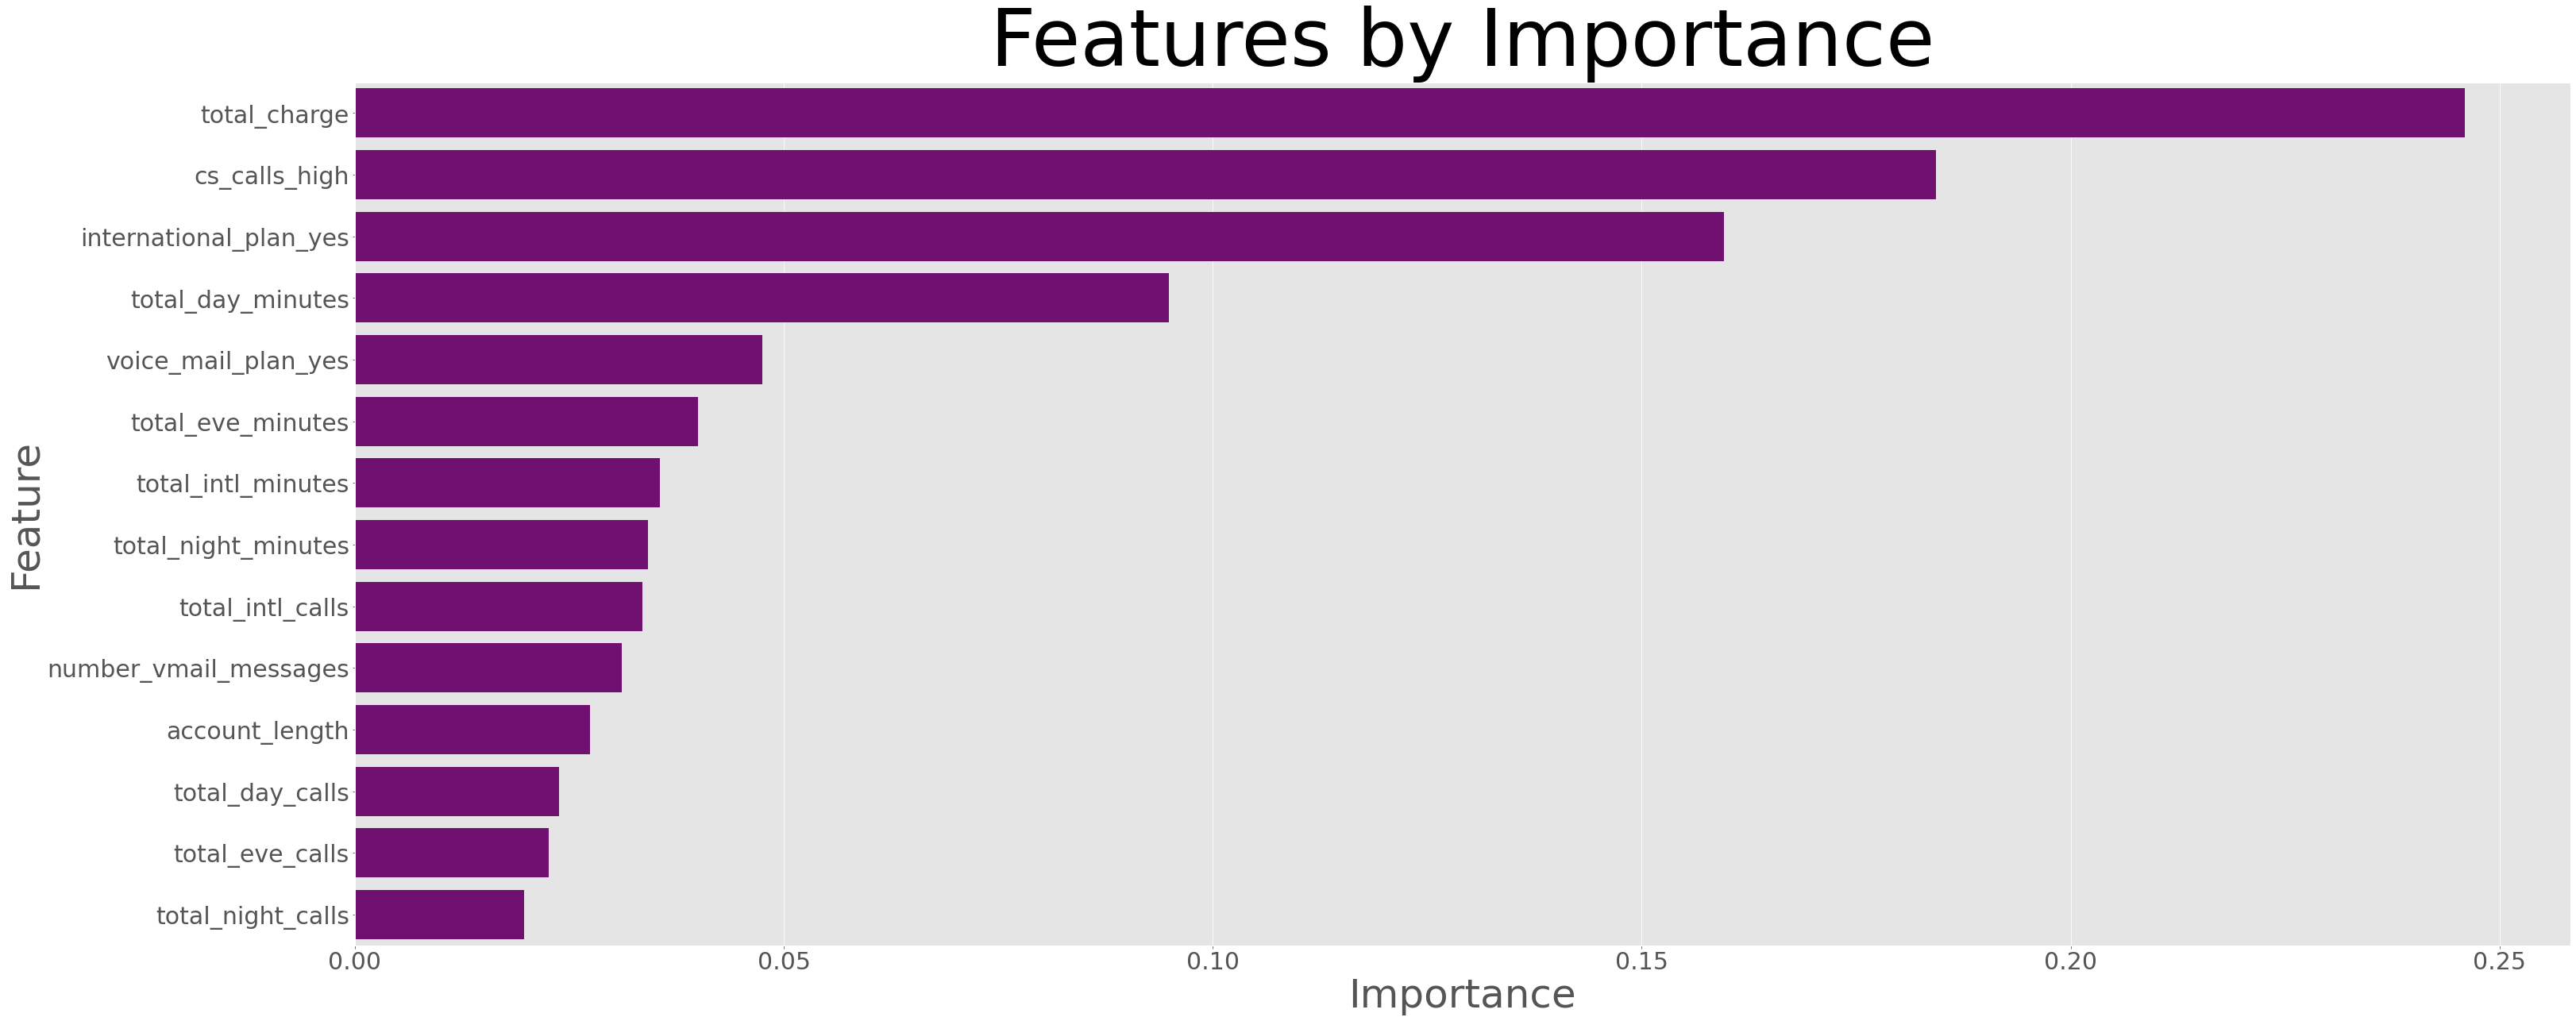

In [60]:
# plot feature importance
fig, ax = plt.subplots(figsize=(50,20))
#p = sns.barplot(data=feature_importance_df, x='Feature', y='Importance' );
p = sns.barplot(data=feature_importance_df, x='Importance', y='Feature', color='purple' );
p.set_xlabel("Importance", fontsize = 50)

p.set_ylabel("Feature", fontsize = 50)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
#p.yaxis.set_major_formatter(display_millions)
p.set_title("Features by Importance", fontsize = 100)
plt.figsize=(30,20) 
#plt.savefig('images/project_1_bar_3')

plt.show();

## Analysis
- Figure out how to rank feature importance as this is the ultimate outcome for my business problem.
- VISUALIZE!!!!

# Analyzing Churn Rate in Important Features

## Customer Service Calls

In [61]:
#cleaned_df.info()

In [62]:
analysis_df = cleaned_df.copy()

In [63]:
cs_churn_df = analysis_df.groupby('customer_service_calls')['churn'].sum().reset_index()
cs_churn_df = cs_churn_df.rename(columns={"customer_service_calls": "#_of_calls"})
variable_1 = analysis_df['customer_service_calls'].value_counts().reset_index()
variable_1 = variable_1.rename(columns={"index": "#_of_calls", "customer_service_calls": "#_of_accounts"})
cs_churn_df = cs_churn_df.merge(variable_1, on='#_of_calls')
churn_rate = cs_churn_df.apply(lambda x: x['churn'] / x['#_of_accounts'], axis=1)
cs_churn_df['churn_rate']= churn_rate
cs_churn_df

,#_of_calls,churn,#_of_accounts,churn_rate
0,0,92,697,0.131994
1,1,122,1181,0.103302
2,2,87,759,0.114625
3,3,44,429,0.102564
4,4,76,166,0.457831
5,5,40,66,0.606061
6,6,14,22,0.636364
7,7,5,9,0.555556
8,8,1,2,0.500000
9,9,2,2,1.000000


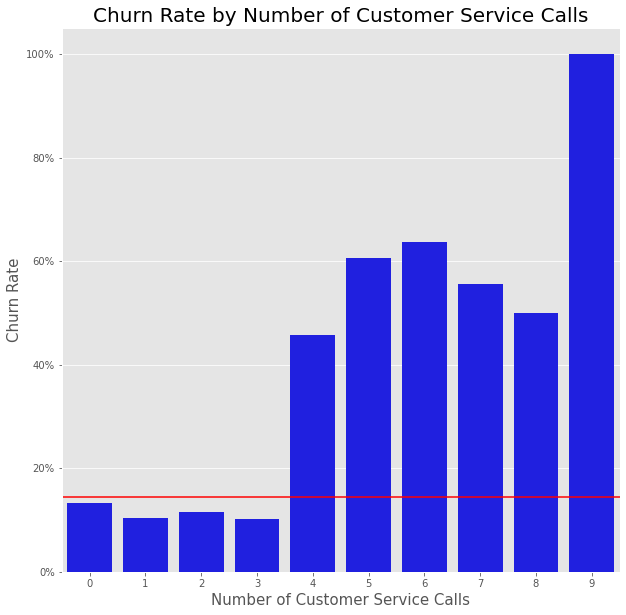

In [146]:
fig, ax = plt.subplots(figsize=(10,10))
p = sns.barplot(x="#_of_calls", y="churn_rate", data=cs_churn_df, color='blue');

p.set_xlabel("Number of Customer Service Calls", fontsize = 15)
p.set_ylabel("Churn Rate", fontsize = 15)
#p.xaxis.set_major_formatter(display_millions)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
p.set_title("Churn Rate by Number of Customer Service Calls", fontsize = 20)
plt.figsize=(30,20) 
plt.axhline(y=.145, color='red')
#plt.savefig('images/project_1_scatter_1')

plt.show();

### Analysis:
- There is a very strong relationship between the number of Customer Service Calls and Churn Rate.
- If there are 0-3 calls, those customers are below the avg. churn rate.
- At 4 Calls, the Churn Rate jumps to 45.7%, 4X the avg. churn rate.
- Hypothesis is that customers that are unhappy (and therefore more likely to cancel their service) are calling customer service more often.

## International Plan

In [65]:
#intl_df = analysis_df[['international_plan_yes', 'international_plan_no', 'total_intl_calls',
#                       'total_intl_charge', 'total_intl_minutes','churn', 'total_charge']]

In [66]:
intl_df = analysis_df[['international_plan_yes', 'international_plan_no', 'churn']]
intl_churn_df = intl_df.groupby('churn').sum().reset_index()
intl_churn_df = intl_churn_df.transpose()
intl_churn_df = intl_churn_df.rename(columns={0: "stayed", 1: "churned"})
intl_churn_df['total'] = intl_churn_df.apply(lambda x: x['stayed'] + x['churned'], axis=1)
intl_churn_df['churn_rate'] = intl_churn_df.apply(lambda x: x['churned'] / x['total'], axis=1)
intl_churn_df

,stayed,churned,total,churn_rate
churn,0.0,1.0,1.0,1.000000
international_plan_yes,186.0,137.0,323.0,0.424149
international_plan_no,2664.0,346.0,3010.0,0.114950


### Analysis:
- churn rate for customers with an international plan is 42.4% vs 11.5% for those without an international plan.
- nearly 4X increase in churn rate.
- customers without an international plan are actually under the avg. churn rate, but remain fairly close.

## Total Charge

In [134]:
analysis_df['total_charge'].describe()

count    3333.000000
mean       59.449754
std        10.502261
min        22.930000
25%        52.380000
50%        59.470000
75%        66.480000
max        96.150000
Name: total_charge, dtype: float64

In [122]:
charge_df = analysis_df[['total_charge', 'churn']]

In [123]:
charge_df['charge_group'] = pd.qcut(analysis_df['total_charge'], 100)

<ipython-input-123-4eb671cf084a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  charge_df['charge_group'] = pd.qcut(analysis_df['total_charge'], 100)


In [107]:
charge_df

,total_charge,churn,charge_group
0,75.56,0,"(74.309, 75.632]"
1,59.24,0,"(58.824, 59.47]"
2,62.29,0,"(62.042, 62.597]"
3,66.80,0,"(66.03, 66.8]"
4,52.09,0,"(51.341, 52.11]"
...,...,...,...
3328,60.10,0,"(60.05, 60.5]"
3329,63.53,0,"(63.195, 63.711]"
3330,67.74,0,"(67.54, 68.236]"
3331,57.53,0,"(57.404, 57.902]"


In [124]:
group_counts = charge_df.charge_group.value_counts().reset_index()

In [125]:
group_counts = group_counts.rename(columns={"index": "charge_group", "charge_group": "#_of_accounts"})

In [126]:
charge_df= charge_df.groupby('charge_group').mean()
charge_df= charge_df.rename(columns={'total_charge': 'group_mean'})
charge_df


,group_mean,churn
charge_group,,
"(22.929, 33.853]",30.850882,0.176471
"(33.853, 37.436]",35.766667,0.060606
"(37.436, 39.44]",38.587273,0.090909
"(39.44, 41.033]",40.203235,0.147059
"(41.033, 42.338]",41.673636,0.060606
"(42.338, 43.319]",42.813939,0.090909
"(43.319, 44.07]",43.695714,0.057143
"(44.07, 44.7]",44.406667,0.151515
"(44.7, 45.338]",45.044062,0.125000


In [127]:
charge_df = charge_df.reset_index()

In [128]:
charge_df = charge_df.merge(group_counts, on='charge_group')

In [129]:
charge_df

,charge_group,group_mean,churn,#_of_accounts
0,"(22.929, 33.853]",30.850882,0.176471,34
1,"(33.853, 37.436]",35.766667,0.060606,33
2,"(37.436, 39.44]",38.587273,0.090909,33
3,"(39.44, 41.033]",40.203235,0.147059,34
4,"(41.033, 42.338]",41.673636,0.060606,33
5,"(42.338, 43.319]",42.813939,0.090909,33
6,"(43.319, 44.07]",43.695714,0.057143,35
7,"(44.07, 44.7]",44.406667,0.151515,33
8,"(44.7, 45.338]",45.044062,0.125000,32
9,"(45.338, 46.02]",45.625143,0.142857,35


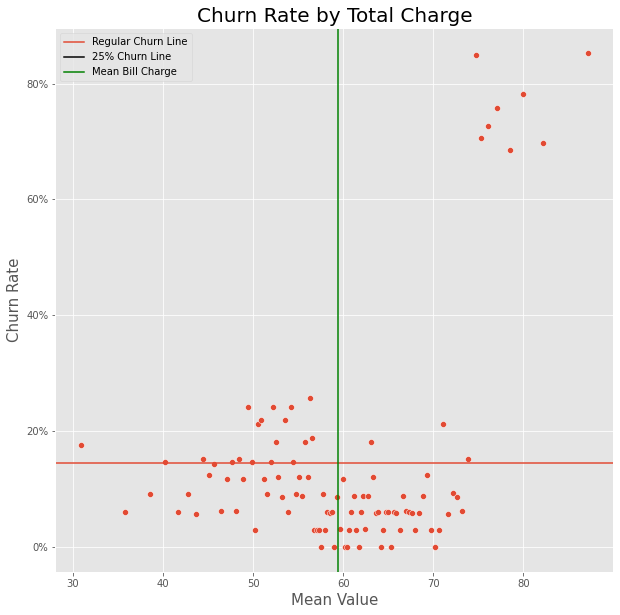

In [143]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots(figsize=(10,10))
p = sns.scatterplot(x="group_mean", y="churn", data=charge_df);

p.set_xlabel("Mean Value", fontsize = 15)
p.set_ylabel("Churn Rate", fontsize = 15)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
#p.xaxis.set_major_formatter(display_millions)

p.set_title("Churn Rate by Total Charge", fontsize = 20)
plt.figsize=(30,20) 

line_1 = plt.axhline(y=.145)
#line_2 = plt.axhline(y=.25, color='black')
line_3 = plt.axvline(x=59.45, color='green')

ax.legend([line_1, line_2, line_3], ['Regular Churn Line', '25% Churn Line', 'Mean Bill Charge'])
#plt.savefig('images/project_1_scatter_1')


plt.show();

### Analysis
- Total Charge of $74/month leads to Churn Rate of roughly 70% or greater!
- While there a a good amount of customers above the average churn line, if you add a standard deviation of 10%, almost all are within that range until you get to the extreme outliers.


# NEW ARCHIVE (2/24)

### Decision Tree 2

In [70]:
dtree_2 = DecisionTreeClassifier(criterion='entropy', 
                           max_depth=5,
                          min_samples_split=10,
                           min_samples_leaf=1,
                            random_state=23)

In [71]:
#dtree_2 = DecisionTreeClassifier(criterion='gini', 
#                           max_depth=3,
#                           min_samples_split=2,
#                           min_samples_leaf=1,
#                            random_state=23)

In [72]:
dtree_2.fit(X_train, y_train)
dt2_y_pred = dtree_2.predict(X_test)

### Evaluating Decision Tree 2

In [73]:
# Calculate Classification Metrics

dt2_acc = accuracy_score(y_test, dt2_y_pred) * 100
print('DTree 2 Accuracy is :{0}'.format(dt2_acc))
dt2_prec = precision_score(y_test, dt2_y_pred) * 100
print('DTree 2 Precision is :{0}'.format(dt2_prec))
dt2_rcl = recall_score(y_test, dt2_y_pred) * 100
print('DTree 2 Recall is :{0}'.format(dt2_rcl))
dt2_f1 = f1_score(y_test, dt1_y_pred) * 100
print('DTree 2 F1 Score is :{0}'.format(dt2_f1))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, dt2_y_pred)
dt2_roc_auc = auc(false_positive_rate, true_positive_rate)
print('DTree 2 AUC is :{0}'.format(round(dt2_roc_auc, 2)))
print('DTree 2 Confusion Matrix')
print('----------------')
pd.crosstab(y_test, dt2_y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

DTree 2 Accuracy is :97.48201438848922
DTree 2 Precision is :100.0
DTree 2 Recall is :82.64462809917356
DTree 2 F1 Score is :11.952191235059761
DTree 2 AUC is :0.91
DTree 2 Confusion Matrix
----------------


Predicted,0,1,All
True,,,
0,713,0,713
1,21,100,121
All,734,100,834


In [74]:
# Calculate accuracy 
#dt2_acc = accuracy_score(y_test,dt2_y_pred) * 100
#print('DTree 2 Accuracy is :{0}'.format(dt2_acc))

# Check the AUC for predictions
#false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, dt2_y_pred)
#dt2_roc_auc = auc(false_positive_rate, true_positive_rate)
#print('DTree 2 AUC is :{0}'.format(round(dt2_roc_auc, 2)))

# Create and print a confusion matrix 
#print('DTree 2 Confusion Matrix')
#print('----------------')
#pd.crosstab(y_test, dt2_y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

### Analysis of Accuracy, AUC, and Confusion Matrix
- Analysis goes HERE
- AND HERE
- AND HERE!

### Random Forests 1

In [75]:
rf1_clf = RandomForestClassifier(random_state=23, class_weight="balanced")
rf1_clf.fit(X_train, y_train)
rf1_y_pred = rf1_clf.predict(X_test)

In [76]:
rf1_clf = RandomForestClassifier(random_state=23, class_weight="balanced")
mean_rf1_cv_score = np.mean(cross_val_score(rf1_clf, X_train, y_train, cv=3))

print(f"Mean Cross Validation Score for Random Forest Classifier: {mean_rf1_cv_score :.2%}")

Mean Cross Validation Score for Random Forest Classifier: 96.92%


In [77]:
rf1_clf.fit(X_train, y_train)
rf1_y_pred = rf1_clf.predict(X_test)
#false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,rf1_y_pred)
#rf1_roc_auc = auc(false_positive_rate, true_positive_rate)
#rf1_roc_auc
#print(f"Random Forests 1 AUC Score: {rf1_roc_auc :.2%}")

### Evaluating Random Forests 1

In [78]:
# Calculate Classification Metrics

rf1_acc = accuracy_score(y_test, rf1_y_pred) * 100
print('Random Forests 1 Accuracy is :{0}'.format(rf1_acc))
rf1_prec = precision_score(y_test, rf1_y_pred) * 100
print('Random Forests 1 Precision is :{0}'.format(rf1_prec))
rf1_rcl = recall_score(y_test, rf1_y_pred) * 100
print('Random Forests 1 Recall is :{0}'.format(rf1_rcl))
rf1_f1 = f1_score(y_test, rf1_y_pred) * 100
print('Random Forests 1 F1 Score is :{0}'.format(rf1_f1))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, rf1_y_pred)
rf1_roc_auc = auc(false_positive_rate, true_positive_rate)
print('Random Forests 1 AUC is :{0}'.format(round(rf1_roc_auc, 2)))
print('Random Forests 1 Confusion Matrix')
print('----------------')
pd.crosstab(y_test, rf1_y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Random Forests 1 Accuracy is :96.76258992805755
Random Forests 1 Precision is :100.0
Random Forests 1 Recall is :77.68595041322314
Random Forests 1 F1 Score is :87.44186046511628
Random Forests 1 AUC is :0.89
Random Forests 1 Confusion Matrix
----------------


Predicted,0,1,All
True,,,
0,713,0,713
1,27,94,121
All,740,94,834


In [79]:
# Calculate accuracy 
#rf1_acc = accuracy_score(y_test,rf1_y_pred) * 100
#print('Random Forests 1 Accuracy is :{0}'.format(rf1_acc))

# Check the AUC for predictions
#false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, rf1_y_pred)
#rf1_roc_auc = auc(false_positive_rate, true_positive_rate)
#print('Random Forests 1 AUC is :{0}'.format(round(rf1_roc_auc, 2)))

# Create and print a confusion matrix 
#print('Random Forests Confusion Matrix')
#print('----------------')
#pd.crosstab(y_test, rf1_y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

## GridSearch_CV & Random Forests 2

In [80]:
rf2_clf = RandomForestClassifier(random_state=23, class_weight="balanced")

In [81]:
rf_param_grid = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

In [82]:
#rf2_grid_search = GridSearchCV(rf2_clf, rf_param_grid, scoring = 'recall', cv=3)
rf2_grid_search = GridSearchCV(rf2_clf, rf_param_grid, scoring = 'f1', cv=3)
rf2_grid_search.fit(X_train, y_train)

print(f"Random Forest 2 Training Accuracy: {rf2_grid_search.best_score_ :.2%}")
print("")
# Mean test score
rf2_gs_testing_score = rf2_grid_search.score(X_test, y_test)
print("")
print(f"Random Forest 2 Optimal Parameters: {rf2_grid_search.best_params_}")

Random Forest 2 Training Accuracy: 90.75%


Random Forest 2 Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 100}


In [83]:
print(f"Random Forests 2 Mean Test Score: {rf2_gs_testing_score :.2%}")

Random Forests 2 Mean Test Score: 90.67%


In [84]:
rf2_clf = RandomForestClassifier(criterion= 'entropy',
                                max_depth= None,
                                min_samples_leaf= 6,
                                min_samples_split= 5,
                                n_estimators= 100)

mean_rf2_cv_score = np.mean(cross_val_score(rf2_clf, X_train, y_train, cv=3))

print(f"Random Forests 2 Mean Cross Validation Score: {mean_rf2_cv_score :.2%}")

Random Forests 2 Mean Cross Validation Score: 95.92%


In [85]:
#rf2_clf = RandomForestClassifier(criterion= 'gini',
#                                max_depth= None,
#                                min_samples_leaf= 3,
#                                min_samples_split= 5,
#                                n_estimators= 100)

#mean_rf2_cv_score = np.mean(cross_val_score(rf2_clf, X_train, y_train, cv=3))

#print(f"Random Forests 2 Mean Cross Validation Score: {mean_rf2_cv_score :.2%}")

In [86]:
rf2_clf.fit(X_train, y_train)
rf2_y_pred = rf2_clf.predict(X_test)
#false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,rf2_y_pred)
#rf2_roc_auc = auc(false_positive_rate, true_positive_rate)
#rf2_roc_auc
#print(f"Random Forests 2 AUC Score: {rf2_roc_auc :.2%}")

### Evaluating Random Forests 2

In [87]:
# Calculate Classification Metrics

rf2_acc = accuracy_score(y_test, rf2_y_pred) * 100
print('Random Forests 2 Accuracy is :{0}'.format(rf2_acc))
rf2_prec = precision_score(y_test, rf2_y_pred) * 100
print('Random Forests 2 Precision is :{0}'.format(rf2_prec))
rf2_rcl = recall_score(y_test, rf2_y_pred) * 100
print('Random Forests 2 Recall is :{0}'.format(rf2_rcl))
rf2_f1 = f1_score(y_test, rf2_y_pred) * 100
print('Random Forests 2 F1 Score is :{0}'.format(rf2_f1))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, rf2_y_pred)
rf2_roc_auc = auc(false_positive_rate, true_positive_rate)
print('Random Forests 2 AUC is :{0}'.format(round(rf2_roc_auc, 2)))
print('Random Forests 2 Confusion Matrix')
print('----------------')
pd.crosstab(y_test, rf2_y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Random Forests 2 Accuracy is :96.88249400479616
Random Forests 2 Precision is :100.0
Random Forests 2 Recall is :78.51239669421489
Random Forests 2 F1 Score is :87.96296296296296
Random Forests 2 AUC is :0.89
Random Forests 2 Confusion Matrix
----------------


Predicted,0,1,All
True,,,
0,713,0,713
1,26,95,121
All,739,95,834


In [88]:
# Calculate accuracy 
#rf2_acc = accuracy_score(y_test,rf2_y_pred) * 100
#print('Random Forests 2 Accuracy is :{0}'.format(rf2_acc))

# Check the AUC for predictions
#false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, rf2_y_pred)
#rf2_roc_auc = auc(false_positive_rate, true_positive_rate)
#print('Random Forests 2 AUC is :{0}'.format(round(rf2_roc_auc, 2)))

# Create and print a confusion matrix 
#print('Random Forests 2 Confusion Matrix')
#print('----------------')
#pd.crosstab(y_test, rf2_y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

In [89]:
#dt2_score = dt2_grid_search.score(X_test, y_test)
#rf2_score = rf2_grid_search.score(X_test, y_test)

#print('Decision tree 2 grid search Score: ', dt2_score)
#print('Random forest 2 grid search Score: ', rf2_score)

## Modeling with Synthetic Samples (SMOTE)

In [90]:
balanced_df = model_df.copy()

X = balanced_df.drop(['churn'], axis=1)
y = balanced_df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y, random_state=23)

smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 

In [91]:
X = balanced_df.drop(['churn'], axis=1)
y = balanced_df['churn']

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y, random_state=23)

In [93]:
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 

## Decision Tree 3

In [94]:
dtree_3 = DecisionTreeClassifier(random_state=23, class_weight="balanced")

dtree_3.fit(X_train_resampled, y_train_resampled)
dt3_y_pred = dtree_3.predict(X_test)

In [95]:
# Calculate Classification Metrics

dt3_acc = accuracy_score(y_test, dt3_y_pred) * 100
print('DTree 3 Accuracy is :{0}'.format(dt3_acc))
dt3_prec = precision_score(y_test, dt3_y_pred) * 100
print('DTree 3 Precision is :{0}'.format(dt3_prec))
dt3_rcl = recall_score(y_test, dt3_y_pred) * 100
print('DTree 3 Recall is :{0}'.format(dt3_rcl))
dt3_f1 = f1_score(y_test, dt3_y_pred) * 100
print('DTree 3 F1 Score is :{0}'.format(dt3_f1))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, dt3_y_pred)
dt3_roc_auc = auc(false_positive_rate, true_positive_rate)
print('DTree 3 AUC is :{0}'.format(round(dt3_roc_auc, 2)))
print('DTree 3 Confusion Matrix')
print('----------------')
pd.crosstab(y_test, dt3_y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

DTree 3 Accuracy is :93.4052757793765
DTree 3 Precision is :73.23943661971832
DTree 3 Recall is :85.9504132231405
DTree 3 F1 Score is :79.08745247148289
DTree 3 AUC is :0.9
DTree 3 Confusion Matrix
----------------


Predicted,0,1,All
True,,,
0,675,38,713
1,17,104,121
All,692,142,834


## GridSearchCV

In [96]:
dt3_grid_search = GridSearchCV(dtree_3, dt_param_grid, cv=3, scoring = 'f1', return_train_score=True)
# Fit to the data
dt3_grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=23),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 3, 4, 5, 6],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [2, 5, 10]},
             return_train_score=True, scoring='f1')

In [97]:
# Mean training score
dt3_gs_training_score = np.mean(dt3_grid_search.cv_results_['mean_train_score'])

# Mean test score
dt3_gs_testing_score = dt3_grid_search.score(X_test, y_test)

print(f"DTree 3 Mean Training Score: {dt3_gs_training_score :.2%}")
print(f"DTree 3 Mean Test Score: {dt3_gs_testing_score :.2%}")
print("DTree 3 Best Parameter Combination Found During Grid Search:")
dt3_grid_search.best_params_

DTree 3 Mean Training Score: 93.59%
DTree 3 Mean Test Score: 80.95%
DTree 3 Best Parameter Combination Found During Grid Search:


{'criterion': 'entropy',
 'max_depth': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2}

## Decision Tree 4

In [98]:
dtree_4 = DecisionTreeClassifier(criterion='entropy', 
                           max_depth=6,
                          min_samples_split=2,
                           min_samples_leaf=3,
                            random_state=23)

In [99]:
dtree_4.fit(X_train_resampled, y_train_resampled)
dt4_y_pred = dtree_4.predict(X_test)

In [100]:
# Calculate Classification Metrics

dt4_acc = accuracy_score(y_test, dt4_y_pred) * 100
print('DTree 4 Accuracy is :{0}'.format(dt4_acc))
dt4_prec = precision_score(y_test, dt3_y_pred) * 100
print('DTree 4 Precision is :{0}'.format(dt4_prec))
dt4_rcl = recall_score(y_test, dt4_y_pred) * 100
print('DTree 4 Recall is :{0}'.format(dt4_rcl))
dt4_f1 = f1_score(y_test, dt4_y_pred) * 100
print('DTree 4 F1 Score is :{0}'.format(dt4_f1))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, dt4_y_pred)
dt4_roc_auc = auc(false_positive_rate, true_positive_rate)
print('DTree 4 AUC is :{0}'.format(round(dt4_roc_auc, 2)))
print('DTree 4 Confusion Matrix')
print('----------------')
pd.crosstab(y_test, dt4_y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

DTree 4 Accuracy is :96.64268585131894
DTree 4 Precision is :73.23943661971832
DTree 4 Recall is :83.47107438016529
DTree 4 F1 Score is :87.82608695652173
DTree 4 AUC is :0.91
DTree 4 Confusion Matrix
----------------


Predicted,0,1,All
True,,,
0,705,8,713
1,20,101,121
All,725,109,834


## Random Forests 3

In [101]:
rf3_clf = RandomForestClassifier(random_state=23, class_weight="balanced")

In [102]:
#rf2_grid_search = GridSearchCV(rf2_clf, rf_param_grid, scoring = 'recall', cv=3)
rf3_grid_search = GridSearchCV(rf3_clf, rf_param_grid, scoring = 'f1', cv=3)
rf3_grid_search.fit(X_train_resampled, y_train_resampled)

print(f"Random Forest 3 Training Accuracy: {rf3_grid_search.best_score_ :.2%}")
print("")
# Mean test score
rf3_gs_testing_score = rf3_grid_search.score(X_test, y_test)
print("")
print(f"Random Forest 3 Optimal Parameters: {rf3_grid_search.best_params_}")

KeyboardInterrupt: 

In [ ]:
rf3_clf = RandomForestClassifier(criterion= 'entropy',
                                max_depth= None,
                                min_samples_leaf= 3,
                                min_samples_split= 5,
                                n_estimators= 100)

mean_rf3_cv_score = np.mean(cross_val_score(rf3_clf, X_train_resampled, y_train_resampled, cv=3))

print(f"Random Forests 3 Mean Cross Validation Score: {mean_rf3_cv_score :.2%}")

In [ ]:
rf3_clf.fit(X_train_resampled, y_train_resampled)
rf3_y_pred = rf3_clf.predict(X_test)

In [ ]:
# Calculate Classification Metrics

rf3_acc = accuracy_score(y_test, rf3_y_pred) * 100
print('Random Forests 3 Accuracy is :{0}'.format(rf3_acc))
rf3_prec = precision_score(y_test, rf3_y_pred) * 100
print('Random Forests 3 Precision is :{0}'.format(rf3_prec))
rf3_rcl = recall_score(y_test, rf3_y_pred) * 100
print('Random Forests 3 Recall is :{0}'.format(rf3_rcl))
rf3_f1 = f1_score(y_test, rf3_y_pred) * 100
print('Random Forests 3 F1 Score is :{0}'.format(rf3_f1))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, rf3_y_pred)
rf3_roc_auc = auc(false_positive_rate, true_positive_rate)
print('Random Forests 3 AUC is :{0}'.format(round(rf3_roc_auc, 2)))
print(f"Random Forest 3 Training Accuracy: {rf3_grid_search.best_score_ :.2%}")
print(f"Random Forests 3 Mean Cross Validation Score: {mean_rf3_cv_score :.2%}")
print('Random Forests 3 Confusion Matrix')
print('----------------')
pd.crosstab(y_test, rf3_y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

In [ ]:
plot_confusion_matrix(rf3_clf, X_test, y_test,
                     cmap='viridis')
plt.show()

## Comparisons

In [ ]:
#Recall
print('DTree 1 Recall is :{0}'.format(dt1_rcl))
print('DTree 2 Recall is :{0}'.format(dt2_rcl))
print('DTree 3 Recall is :{0}'.format(dt3_rcl))
print('DTree 4 Recall is :{0}'.format(dt4_rcl))
print('Random Forests 1 Recall is :{0}'.format(rf1_rcl))
print('Random Forests 2 Recall is :{0}'.format(rf2_rcl))
print('Random Forests 3 Recall is :{0}'.format(rf3_rcl))

In [ ]:
#Precision
print('DTree 1 Precision is :{0}'.format(dt1_prec))
print('DTree 2 Precision is :{0}'.format(dt2_prec))
print('DTree 3 Precision is :{0}'.format(dt3_prec))
print('DTree 4 Precision is :{0}'.format(dt4_prec))
print('Random Forests 1 Precision is :{0}'.format(rf1_prec))
print('Random Forests 2 Precision is :{0}'.format(rf2_prec))
print('Random Forests 3 Precision is :{0}'.format(rf3_prec))

In [ ]:
#F1 Score
print('DTree 1 F1 Score is :{0}'.format(dt1_f1))
print('DTree 2 F1 Score is :{0}'.format(dt2_f1))
print('DTree 3 F1 Score is :{0}'.format(dt3_f1))
print('DTree 4 F1 Score is :{0}'.format(dt4_f1))
print('Random Forests 1 F1 Score is :{0}'.format(rf1_f1))
print('Random Forests 2 F1 Score is :{0}'.format(rf2_f1))
print('Random Forests 3 F1 Score is :{0}'.format(rf3_f1))

In [ ]:
#ROC AUC
print('DTree 1 AUC is :{0}'.format(round(dt1_roc_auc, 2)))
print('DTree 2 AUC is :{0}'.format(round(dt2_roc_auc, 2)))
print('DTree 3 AUC is :{0}'.format(round(dt3_roc_auc, 2)))
print('DTree 4 AUC is :{0}'.format(round(dt4_roc_auc, 2)))
print('Random Forests 1 AUC is :{0}'.format(round(rf1_roc_auc, 2)))
print('Random Forests 2 AUC is :{0}'.format(round(rf2_roc_auc, 2)))
print('Random Forests 3 AUC is :{0}'.format(round(rf3_roc_auc, 2)))

In [ ]:
#Accuracy
print('DTree 1 Accuracy is :{0}'.format(dt1_acc))
print('DTree 2 Accuracy is :{0}'.format(dt2_acc))
print('DTree 3 Accuracy is :{0}'.format(dt3_acc))
print('DTree 4 Accuracy is :{0}'.format(dt4_acc))
print('Random Forests 1 Accuracy is :{0}'.format(rf1_acc))
print('Random Forests 2 Accuracy is :{0}'.format(rf2_acc))
print('Random Forests 3 Accuracy is :{0}'.format(rf3_acc))

In [ ]:
print('\n DTree 1 Confusion Matrix')
print('----------------')
print(pd.crosstab(y_test, dt1_y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
print('----------------')
print('----------------')
print('DTree 2 Confusion Matrix')
print('----------------')
print(pd.crosstab(y_test, dt2_y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
print('----------------')
print('----------------')
print('DTree 3 Confusion Matrix')
print('----------------')
print(pd.crosstab(y_test, dt3_y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
print('----------------')
print('----------------')
print('DTree 4 Confusion Matrix')
print('----------------')
print(pd.crosstab(y_test, dt4_y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
print('----------------')
print('----------------')
print('Random Forests 1 Confusion Matrix')
print('----------------')
print(pd.crosstab(y_test, rf1_y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
print('----------------')
print('----------------')
print('Random Forests 2 Confusion Matrix')
print('----------------')
print(pd.crosstab(y_test, rf2_y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
print('----------------')
print('----------------')
print('Random Forests 3 Confusion Matrix')
print('----------------')
print(pd.crosstab(y_test, rf3_y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

In [ ]:
#Comparing the Tuned Models
print(f"DTree 2 Mean Training Score: {dt2_gs_training_score :.2%}")
print(f"DTree 2 Mean Test Score: {dt2_gs_testing_score :.2%}")
print('--------------------------------')
print(f"Random Forest 2 Training Accuracy: {rf2_grid_search.best_score_ :.2%}")
print(f"Random Forest 2 Mean Test Score: {rf2_gs_testing_score :.2%}")

In [ ]:
#print(f"DTree 1 Mean Cross Validation Score: {mean_dt1_cv_score :.2%}")
#print(f"DTree 1 Mean Training Score: {dt1_gs_training_score :.2%}")
#print(f"DTree 1 Mean Test Score: {dt1_gs_testing_score :.2%}")
#print('Decision tree 1 grid search Score: ', dt1_score)
#print(f"DTree 1 AUC Score: {dt1_roc_auc :.2%}")
print('--------------------------------')
#print(f"RandomForest 1 Mean Cross Validation Score: {mean_rf1_cv_score :.2%}")
#print(f"Random Forest 1 Training Accuracy: {rf1_grid_search.best_score_ :.2%}")
#print('Random forest 1 grid search Score: ', rf1_score)
#print(f"Random Forests 1 AUC Score: {rf1_roc_auc :.2%}")
print('--------------------------------')
#print(f"DTree 2 Mean Cross Validation Score: {mean_dt2_cv_score :.2%}")
print('--------------------------------')
#print(f"Random Forests 2 Mean Cross Validation Score: {mean_rf2_cv_score :.2%}")


### Analysis:
    - Explain what cross validation score means
    - explain what training score means
    - explain what test score means
    - explain what grid search score means
    - explain what ROC AUC score means

## Optimal Parameters

In [ ]:
#print("DTree 2 Best Parameter Combination Found During Grid Search:")
#dt2_grid_search.best_params_

In [ ]:
print(f"Random Forest 1 Optimal Parameters: {rf2_grid_search.best_params_}")

## Feature Importance

### Currently set to analyze Random Forests 3

In [ ]:
#final_model = 

In [ ]:
feature_names = list(X)
feature_names

In [ ]:
rf2_importance = rf2_clf.feature_importances_
rf2_importance

In [ ]:
#dt2_importance = dtree_2.feature_importances_
#dt2_importance

###  SORTED

In [ ]:
#feature_importance_df = pd.DataFrame(rf2_importance, feature_names)
feature_importance_df = pd.DataFrame(rf2_importance, feature_names)
feature_importance_df= feature_importance_df.reset_index()
feature_importance_df.rename(columns={'index': 'Feature', 0: 'Importance'}, inplace=True)
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
feature_importance_df

In [ ]:
# plot feature importance
fig, ax = plt.subplots(figsize=(50,20))
#p = sns.barplot(data=feature_importance_df, x='Feature', y='Importance' );
p = sns.barplot(data=feature_importance_df, x='Importance', y='Feature', color='purple' );
p.set_xlabel("Importance", fontsize = 50)

p.set_ylabel("Feature", fontsize = 50)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
#p.yaxis.set_major_formatter(display_millions)
p.set_title("Features by Importance", fontsize = 100)
plt.figsize=(30,20) 
#plt.savefig('images/project_1_bar_3')

plt.show();

In [ ]:
X.info()

## Analysis
- Figure out how to rank feature importance as this is the ultimate outcome for my business problem.
- VISUALIZE!!!!

# Analysis of Churn Rate

In [ ]:
analysis_df = cleaned_df.copy()

New as of 2/22 5PM

## Customer Service Calls vs. Churn

In [ ]:
cs_churn_df = analysis_df.groupby('customer_service_calls')['churn'].sum().reset_index()
cs_churn_df = cs_churn_df.rename(columns={"customer_service_calls": "#_of_calls"})
variable_1 = analysis_df['customer_service_calls'].value_counts().reset_index()
variable_1 = variable_1.rename(columns={"index": "#_of_calls", "customer_service_calls": "#_of_accounts"})
cs_churn_df = cs_churn_df.merge(variable_1, on='#_of_calls')
churn_rate = cs_churn_df.apply(lambda x: x['churn'] / x['#_of_accounts'], axis=1)
cs_churn_df['churn_rate']= churn_rate
cs_churn_df

In [ ]:
cs_churn_df

In [ ]:
cs_churn_df = cs_churn_df.rename(columns={"customer_service_calls": "#_of_calls"})

In [ ]:
cs_churn_df

In [ ]:
variable_1 = analysis_df['customer_service_calls'].value_counts().reset_index()

In [ ]:
analysis_df['customer_service_calls'].value_counts()

In [ ]:
variable_1 = variable_1.rename(columns={"index": "#_of_calls", "customer_service_calls": "#_of_accounts"})

In [ ]:
variable_1

In [ ]:
cs_churn_df = cs_churn_df.merge(variable_1, on='#_of_calls')
cs_churn_df

In [ ]:
churn_rate = cs_churn_df.apply(lambda x: x['churn'] / x['#_of_accounts'], axis=1)
cs_churn_df['churn_rate']= churn_rate

In [ ]:
cs_churn_df

### Visualization: Customer Service Call Churn Rate 

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
p = sns.barplot(x="#_of_calls", y="churn_rate", data=cs_churn_df, color='red');

p.set_xlabel("Number of Customer Service Calls", fontsize = 15)
p.set_ylabel("Churn Rate", fontsize = 15)
#p.xaxis.set_major_formatter(display_millions)
p.set_title("Churn Rate by Number of Customer Service Calls", fontsize = 20)
plt.figsize=(30,20) 
plt.axhline(y=.145)
#plt.savefig('images/project_1_scatter_1')

plt.show();

### Analysis:

## Total Minute Analysis
Churn rate is nearly 50% when day minutes are 250 or more.

In [ ]:
analysis_df['total_day_minutes'].describe()

In [ ]:
analysis_df.info()

In [ ]:
analysis_df['total_minutes'] =analysis_df.apply(lambda x: x['total_day_minutes'] + x['total_eve_minutes']
                                                + x['total_night_minutes'] + x['total_intl_minutes']
                                                                                    , axis=1)

In [ ]:
analysis_df.head()

In [ ]:
analysis_df['total_minutes_grouped'] = analysis_df['total_minutes_grouped']
analysis_df

In [ ]:
#bin_labels_5 = ['478', '516', '545', '570', '593', '614', '638', '667', '707', '885']
#analysis_df['total_minutes_grouped'] = pd.qcut(analysis_df['total_minutes_grouped'], 10, labels=bin_labels_5)
                              
#analysis_df.head()

In [ ]:
total_min_grouped_churn = analysis_df.groupby('total_minutes_grouped')['churn'].sum().reset_index()
total_min_grouped_churn

In [ ]:
total_min_grouped_values = analysis_df['total_minutes_grouped'].value_counts().reset_index()
total_min_grouped_values

In [ ]:
total_min_grouped_values = total_min_grouped_values.rename(columns={"total_minutes_grouped": "#_of_accounts", "index": "total_minutes_grouped"})
total_min_grouped_values

In [ ]:
total_min_grouped_df = total_min_grouped_churn.merge(total_min_grouped_values, on='total_minutes_grouped')
                                                       
total_min_grouped_df

In [ ]:
total_min_grouped_df['churn_rate'] = total_min_grouped_df.apply(lambda x: x['churn'] / x['#_of_accounts'], axis=1)
total_min_grouped_df

### Visualization

In [ ]:
import matplotlib.ticker as mtick

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
p = sns.barplot(x="total_minutes_grouped", y="churn_rate", data=total_min_grouped_df, color='yellow');

p.set_xlabel("Total Minutes", fontsize = 15)
p.set_ylabel("Churn Rate", fontsize = 15)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
#ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
p.set_title("Churn Rate by Total Minutes", fontsize = 20)
plt.figsize=(30,20) 
plt.axhline(y=.145)
#plt.savefig('images/project_1_scatter_1')

plt.show();

## International Plan

In [ ]:
test_df.info()

In [ ]:
need_to_encode_2 = test_df[['voice_mail_plan', 'international_plan', 'churn']]

In [ ]:
ohe.fit(need_to_encode_2)

ohe_2 = ohe.transform(need_to_encode_2).toarray()

feature_churn_df= pd.DataFrame(ohe_2, columns=ohe.get_feature_names(need_to_encode_2.columns))
feature_churn_df.head()

In [ ]:
feature_churn_df = feature_churn_df.drop('churn_0', axis=1)

In [ ]:
feature_churn_df = feature_churn_df.groupby('churn_1').sum().reset_index()

In [ ]:
feature_churn_df = feature_churn_df.transpose()
feature_churn_df

In [ ]:
feature_churn_df = feature_churn_df.rename(columns={0: "stayed", 1: "churned"})
feature_churn_df

In [ ]:
feature_churn_df['total'] = feature_churn_df.apply(lambda x: x['stayed'] + x['churned'], axis=1)
feature_churn_df

In [ ]:
feature_churn_df['total'] = feature_churn_df.apply(lambda x: x['stayed'] + x['churned'], axis=1)

In [ ]:
feature_churn_df['total'] = feature_churn_df.apply(lambda x: x['stayed'] + x['churned'], axis=1)

### Analysis:
- churn rate for customers with an international plan is 42.4% vs 11.5% for those without an international plan.
- nearly 4X increase

## Total Charge

In [ ]:
analysis_df['total_charge'].describe()

In [ ]:
analysis_df['charge_group'] = pd.qcut(analysis_df['total_charge'], 10)

In [ ]:
#copy and paste this
total_charge_df = analysis_df
total_charge_df['charge_group'] = pd.qcut(total_charge_df['total_charge'], 10)
total_charge_df = total_charge_df.groupby('charge_group')['churn'].sum().reset_index()


total_charge_df

In [ ]:
charge_group_values = total_charge_df['charge_group'].value_counts()
charge_group_values = charge_group_values.reset_index()
charge_group_values = charge_group_values.rename(columns={"index": "total_charge",
                                                          "charge_group": "#_of_accounts"})
total_charge_df = total_charge_df.merge(charge_group_values, on="total_charge")
total_charge_df


total_charge_df['churn_rate'] = total_charge_df.apply(lambda x: x['churn'] / x['#_of_accounts'], axis=1)
total_charge_df

In [ ]:
total_charge_df = analysis_df.groupby('charge_group')['churn'].sum().reset_index()

In [ ]:
charge_group_values = analysis_df['charge_group'].value_counts()
charge_group_values

In [ ]:
blah = charge_group_values.reset_index()
blah

In [ ]:
blah = blah.rename(columns={"index": "total_charge", "charge_group": "#_of_accounts"})
blah
                            

In [ ]:
total_charge_df = total_charge_df.rename(columns={"charge_group": "total_charge"})

In [ ]:
total_charge_df = total_charge_df.merge(blah, on="total_charge")
total_charge_df

In [ ]:
total_charge_df['churn_rate'] = total_charge_df.apply(lambda x: x['churn'] / x['#_of_accounts'], axis=1)
total_charge_df

In [ ]:
testing =  total_charge_df.replace(to_replace=('(22.929, 46.02]', value= '('bin1')')
testing

In [ ]:
analysis_df.sort_values('total_charge', ascending=False).head(999)

### Visualization

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
p = sns.barplot(x="total_charge", y="churn_rate", data=total_charge_df, color='green');

p.set_xlabel("Total Charge", fontsize = 15)
p.set_ylabel("Churn Rate", fontsize = 15)
#p.xaxis.set_major_formatter(display_millions)
p.set_title("Churn Rate by TotalCharge", fontsize = 20)
plt.figsize=(30,20) 
plt.axhline(y=.145)
#plt.savefig('images/project_1_scatter_1')

plt.show();

# Conclusions

## Questions to Answer: Revisited

## Recommendations

# Summary

# Archive

## Visualizations

In [ ]:
sns.scatterplot(data=analysis_df['total_charge'])

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
p = sns.scatterplot(x="total_charge", y="ROI", data=analysis_df);

p.set_xlabel("Budget", fontsize = 15)
p.set_ylabel("ROI", fontsize = 15)
p.xaxis.set_major_formatter(display_millions)
p.set_title("Distribution of Recent Animated and Adventure Movies by Budget", fontsize = 20)
plt.figsize=(30,20) 
plt.axhline(y=0)
plt.savefig('images/project_1_scatter_1')

plt.show();

## Analysis of Churned Customers (Old)

In [ ]:
cleaned_df

In [ ]:
churned_df = cleaned_df[cleaned_df["churn_1"] == 1]
churned_df

In [ ]:
churned_df.info()

In [ ]:
churn_means = churned_df.mean()

In [ ]:
stayed_df = cleaned_df[cleaned_df["churn_1"] == 0]
stayed_df

In [ ]:
stayed_means = stayed_df.mean()

In [ ]:
stayed_means = stayed_means.reset_index()

In [ ]:
stayed_means = stayed_means.rename(columns={0: "Stayed"})

In [ ]:
stayed_means

In [ ]:
churn_means = churn_means.reset_index()

In [ ]:
churn_means = churn_means.rename(columns={0: "Left"})

In [ ]:
new_df = pd.merge(stayed_means, churn_means, on= 'index')
new_df.head()

In [ ]:
#new_df = new_df.drop(columns=['level_0_x', 'level_0_y'], axis=1)
#new_df.head()

In [ ]:
new_df['Delta']= new_df.apply(lambda x: x['Left'] - x['Stayed'], axis=1)

In [ ]:
new_df

In [ ]:
#churned_df.sort_values('cs_calls_4_5_6', ascending=False)

In [ ]:
churned_df.info()

In [ ]:
churned_df_cat = churned_df[['cs_calls_high','voice_mail_plan_yes', 'international_plan_yes']]
churned_df_cat


In [ ]:
churned_df_cat.sum()

In [ ]:
stayed_df_cat = stayed_df[['cs_calls_high','voice_mail_plan_yes', 'international_plan_yes']]
stayed_df_cat

In [ ]:
stayed_df_cat.sum()

In [ ]:
churned_df.info()

In [ ]:
churned_df_num = churned_df[['account_length', "number_vmail_messages", "total_day_calls", "total_eve_calls",
                             "total_night_minutes", "total_night_calls", "total_intl_calls",
                             "total_intl_minutes",]]

In [ ]:
#churned_df_num = churned_df[['account_length', "number_vmail_messages", "total_day_calls", "total_day_charge",
#                             "total_eve_calls", "total_eve_charge", "total_night_minutes", "total_night_calls",
#                             "total_night_charge", "total_intl_calls", "total_intl_minutes", "total_intl_charge"
#                            ]]

In [ ]:
stayed_df_num = stayed_df[['account_length', "number_vmail_messages", "total_day_calls", "total_eve_calls",
                             "total_night_minutes", "total_night_calls", "total_intl_calls",
                             "total_intl_minutes",]]

In [ ]:
#stayed_df_num = stayed_df[['account_length', "number_vmail_messages", "total_day_calls", "total_day_charge",
#                             "total_eve_calls", "total_eve_charge", "total_night_minutes", "total_night_calls",
#                             "total_night_charge", "total_intl_calls", "total_intl_minutes", "total_intl_charge"
#                            ]]

In [ ]:
churned_df_num.mean()

In [ ]:
churned_df_num.describe()

In [ ]:
stayed_df_num.mean()

In [ ]:
churned_df_num['total_day_charge'].value_counts()